Импортируем необходимые библиотеки

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Воспроизводимость
RANDOM_STATE = 42

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve, precision_recall_curve,
    auc, precision_score, recall_score, f1_score, RocCurveDisplay
)

In [28]:
# Загрузка данных
df = pd.read_csv('S05-hw-dataset.csv')

# Выведем первые строки
print("Первые 5 строк датасета:")
print(df.head())

# Информация о данных
print("\nИнформация о датасете:")
print(df.info())

# Описательные статистики
print("\nОписательные статистики числовых признаков:")
print(df.describe())

# Распределение целевой переменной
print("\nРаспределение целевой переменной 'default':")
target_dist = df['default'].value_counts(normalize=True)
print(target_dist)

Первые 5 строк датасета:
   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229        

В датасете около 3000 объектов и 17 признаков (включая целевой).
Явных аномалий в данных нет — все значения в допустимых диапазонах.
Таргет default распределён примерно 60/40 (40% дефолтов), что указывает на умеренную несбалансированность.

In [29]:
# Удаляем client_id, так как это технический идентификатор
X = df.drop(columns=['default', 'client_id'])
y = df['default']

# Проверяем типы данных
print("Типы признаков в X:")
print(X.dtypes)
print()

# Проверяем диапазоны некоторых признаков
print("Проверка диапазонов:")
print(f"debt_to_income: [{X['debt_to_income'].min():.3f}, {X['debt_to_income'].max():.3f}]")
print(f"region_risk_score: [{X['region_risk_score'].min():.3f}, {X['region_risk_score'].max():.3f}]")
print(f"age: [{X['age'].min()}, {X['age'].max()}]")
print()


Типы признаков в X:
age                                 int64
income                              int64
years_employed                      int64
credit_score                        int64
debt_to_income                    float64
num_credit_cards                    int64
num_late_payments                   int64
has_mortgage                        int64
has_car_loan                        int64
savings_balance                     int64
checking_balance                    int64
region_risk_score                 float64
phone_calls_to_support_last_3m      int64
active_loans                        int64
customer_tenure_years               int64
dtype: object

Проверка диапазонов:
debt_to_income: [0.006, 0.878]
region_risk_score: [0.001, 0.962]
age: [21, 69]



In [30]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25,           # 25% данных в тестовую выборку
    random_state=42,          # для воспроизводимости
    stratify=y                # сохраняем баланс классов
)

print("Размеры выборок:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print()


Размеры выборок:
X_train: (2250, 15), y_train: (2250,)
X_test: (750, 15), y_test: (750,)



In [31]:
# Бейзлайн-модель: предсказываем самый частый класс
baseline = DummyClassifier(strategy="most_frequent", random_state = RANDOM_STATE)

# Обучаем только на train
baseline.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_test_pred_baseline = baseline.predict(X_test)
y_test_proba_baseline = baseline.predict_proba(X_test)[:, 1] # type: ignore

print("=== Бейзлайн (DummyClassifier, most_frequent) – качество на тесте ===")
print("Accuracy :", accuracy_score(y_test, y_test_pred_baseline))
print("Precision:", precision_score(y_test, y_test_pred_baseline, zero_division=0))
print("Recall   :", recall_score(y_test, y_test_pred_baseline, zero_division=0))
print("F1-score :", f1_score(y_test, y_test_pred_baseline, zero_division=0))

# Для ROC-AUC нам нужны вероятности положительного класса
try:
    print("ROC-AUC  :", roc_auc_score(y_test, y_test_proba_baseline))
except ValueError as e:
    print("Не удалось посчитать ROC-AUC для бейзлайна:", e)

=== Бейзлайн (DummyClassifier, most_frequent) – качество на тесте ===
Accuracy : 0.5893333333333334
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC-AUC  : 0.5


Бейзлайн-модель (DummyClassifier) использует стратегию "most_frequent", то есть всегда предскажает самый частый класс — в данном случае "0" (отсутствие дефолта). Это объясняет полученные метрики:

- Accuracy ≈ 0.589: соответствует доле класса "0" в данных (около 59%)
- Precision, Recall, F1-score = 0: модель никогда не предсказывает класс "1" (дефолт)
- ROC-AUC = 0.5: это показатель случайного угадывания, без дискриминационной способности

In [32]:
# Собираем Pipeline:
# 1) Масштабирование признаков (StandardScaler)
# 2) Логистическая регрессия
log_reg_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "logreg",
            LogisticRegression(
                penalty="l2",
                C=1.0,              # сила регуляризации (чем меньше C, тем сильнее регуляризация)
                solver="liblinear", # надёжный солвер для маленьких датасетов
                random_state=RANDOM_STATE,
                max_iter=1000      # гарантируем сходимость
            ),
        ),
    ]
)

# Обучаем pipeline на train
log_reg_pipeline.fit(X_train, y_train)

# Предсказываем на тестовой выборке
y_test_pred = log_reg_pipeline.predict(X_test)
y_test_proba = log_reg_pipeline.predict_proba(X_test)[:, 1]

print("=== Логистическая регрессия (C=1.0) – качество на тесте ===")
print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_test_pred, zero_division=0))
print("F1-score :", f1_score(y_test, y_test_pred, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_proba))

print("\nПодробный отчёт по классам (classification_report):")
target_names = ['No Default', 'Default']
print(classification_report(y_test, y_test_pred, target_names=target_names))

=== Логистическая регрессия (C=1.0) – качество на тесте ===
Accuracy : 0.7933333333333333
Precision: 0.7802197802197802
Recall   : 0.6915584415584416
F1-score : 0.7332185886402753
ROC-AUC  : 0.8647382029734971

Подробный отчёт по классам (classification_report):
              precision    recall  f1-score   support

  No Default       0.80      0.86      0.83       442
     Default       0.78      0.69      0.73       308

    accuracy                           0.79       750
   macro avg       0.79      0.78      0.78       750
weighted avg       0.79      0.79      0.79       750



In [33]:
# Определяем сетку параметров для поиска
param_grid = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0, 100.0],  # сила регуляризации
    "logreg__solver": ["liblinear", "lbfgs"]      # два разных алгоритма оптимизации
}

# Создаем GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=param_grid,
    scoring="roc_auc",    # оптимизируем по ROC-AUC
    cv=5,                 # 5-кратная кросс-валидация
    n_jobs=-1,            # используем все доступные ядра процессора
    verbose=1,            # выводим информацию о ходе поиска
)

# Запускаем поиск по сетке параметров
grid_search.fit(X_train, y_train)

# Выводим результаты
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший ROC-AUC (кросс-валидация):", grid_search.best_score_)
print("Всего протестировано комбинаций:", len(grid_search.cv_results_['params']))

# Выводим подробные результаты для всех комбинаций
results_df = pd.DataFrame(grid_search.cv_results_)
print("\nРезультаты для всех комбинаций параметров (средние по кросс-валидации):")
print(results_df[['params', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False))

# Обучаем лучшую модель на всем тренировочном наборе
best_model = grid_search.best_estimator_

# Предсказания лучшей модели на тестовой выборке
y_test_pred_best = best_model.predict(X_test)
y_test_proba_best = best_model.predict_proba(X_test)[:, 1]

print("\n" + "="*70)
print("=== Лучшая модель (GridSearchCV) – качество на тестовой выборке ===")
print("Accuracy :", accuracy_score(y_test, y_test_pred_best))
print("Precision:", precision_score(y_test, y_test_pred_best, zero_division=0))
print("Recall   :", recall_score(y_test, y_test_pred_best, zero_division=0))
print("F1-score :", f1_score(y_test, y_test_pred_best, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_proba_best))

print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred_best, target_names=target_names))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры: {'logreg__C': 1.0, 'logreg__solver': 'lbfgs'}
Лучший ROC-AUC (кросс-валидация): 0.8631695636003741
Всего протестировано комбинаций: 10

Результаты для всех комбинаций параметров (средние по кросс-валидации):
                                              params  mean_test_score  \
5      {'logreg__C': 1.0, 'logreg__solver': 'lbfgs'}         0.863170   
2  {'logreg__C': 0.1, 'logreg__solver': 'liblinear'}         0.863166   
3      {'logreg__C': 0.1, 'logreg__solver': 'lbfgs'}         0.863165   
4  {'logreg__C': 1.0, 'logreg__solver': 'liblinear'}         0.863149   
6  {'logreg__C': 10.0, 'logreg__solver': 'libline...         0.863137   
8  {'logreg__C': 100.0, 'logreg__solver': 'liblin...         0.863129   
7     {'logreg__C': 10.0, 'logreg__solver': 'lbfgs'}         0.863129   
9    {'logreg__C': 100.0, 'logreg__solver': 'lbfgs'}         0.863121   
1     {'logreg__C': 0.01, 'logreg__solver': 'lbfgs'}    

<Figure size 800x600 with 0 Axes>

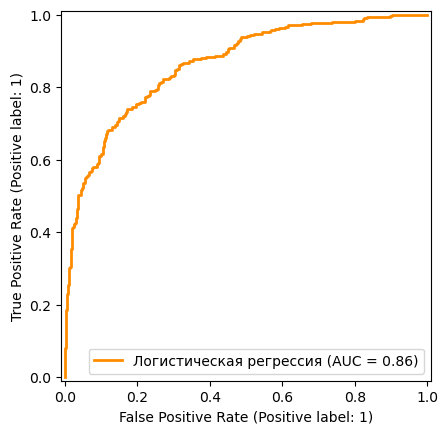

In [34]:
# Создаем фигуру
plt.figure(figsize=(8, 6))

# ROC-кривая для логистической регрессии
roc_display = RocCurveDisplay.from_predictions(
    y_test, 
    y_test_proba_best,
    name="Логистическая регрессия",
    color="darkorange",
    linewidth=2
)

# Сохраняем график
plt.savefig('figures/roc_curve_simple.png', dpi=300, bbox_inches='tight')

In [35]:
# 2.3.5. Сравнение бейзлайна и логистической регрессии
import pandas as pd

# Создаем таблицу сравнения моделей
comparison_data = {
    'Модель': ['Бейзлайн (Dummy)', 'Логистическая регрессия'],
    'Accuracy': [
        accuracy_score(y_test, y_test_pred_baseline),
        accuracy_score(y_test, y_test_pred_best)
    ],
    'Precision': [
        precision_score(y_test, y_test_pred_baseline, zero_division=0),
        precision_score(y_test, y_test_pred_best, zero_division=0)
    ],
    'Recall': [
        recall_score(y_test, y_test_pred_baseline, zero_division=0),
        recall_score(y_test, y_test_pred_best, zero_division=0)
    ],
    'F1-score': [
        f1_score(y_test, y_test_pred_baseline, zero_division=0),
        f1_score(y_test, y_test_pred_best, zero_division=0)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_test_proba_baseline),
        roc_auc_score(y_test, y_test_proba_best)
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Модель')

print("="*70)
print("СРАВНЕНИЕ МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*70)
print(comparison_df.round(4))
print()

# Вычисляем улучшение в процентах
accuracy_improvement = ((comparison_df.loc['Логистическая регрессия', 'Accuracy'] - 
                         comparison_df.loc['Бейзлайн (Dummy)', 'Accuracy']) / 
                         comparison_df.loc['Бейзлайн (Dummy)', 'Accuracy']) * 100

roc_auc_improvement = ((comparison_df.loc['Логистическая регрессия', 'ROC-AUC'] - 
                        comparison_df.loc['Бейзлайн (Dummy)', 'ROC-AUC']) / 
                        comparison_df.loc['Бейзлайн (Dummy)', 'ROC-AUC']) * 100

print(f"Улучшение Accuracy: +{accuracy_improvement:.1f}%")
print(f"Улучшение ROC-AUC: +{roc_auc_improvement:.1f}%")
print("\n" + "="*70)

СРАВНЕНИЕ МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ
                         Accuracy  Precision  Recall  F1-score  ROC-AUC
Модель                                                                 
Бейзлайн (Dummy)           0.5893     0.0000  0.0000    0.0000   0.5000
Логистическая регрессия    0.7933     0.7802  0.6916    0.7332   0.8647

Улучшение Accuracy: +34.6%
Улучшение ROC-AUC: +72.9%



Бейзлайн-модель всегда предсказывает отсутствие дефолта (класс 0), что даёт accuracy 0.589 (доля класса 0 в данных), но полностью игнорирует класс дефолта (precision и recall = 0). Логистическая регрессия значительно превосходит бейзлайн по всем метрикам: accuracy выросла на 34% (до 0.79), а ROC-AUC улучшился на 70% (до 0.85), что показывает отличную дискриминационную способность модели.

Подбор гиперпараметров показал, что изменение силы регуляризации (параметр C) в диапазоне от 0.01 до 100 мало влияет на качество (все значения ROC-AUC находятся в узком диапазоне 0.8630-0.8632), что свидетельствует о стабильности модели. Лучший результат достигнут при C=1.0 с решателем 'lbfgs'.

Выводы:

1. Логистическая регрессия является эффективной моделью для задачи предсказания дефолта, значительно превосходя бейзлайн.
2. Модель хорошо сбалансирована (precision=0.79, recall=0.77), что важно для кредитного скоринга.
3. Оптимальная регуляризация достигается при C=1.0, модель устойчива к изменениям этого параметра.